In [307]:

import os
import numpy as np
import matplotlib.pyplot as plt
import re
import scipy.signal as signal
#path = r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\29-08 IN" #24-07\2024-07-24_11-09-09test_Homodyne.txt"

In [106]:
get_paths_intensity(directory)[:-10]#[0][-24:-16]

['O:\\Tech_Photonics\\Projects\\Narrow Linewidth\\MFB Chips\\Chip 3 Feedback measurements\\29-8 RIN\\2024-08-29_16-14-37esa.txt',
 'O:\\Tech_Photonics\\Projects\\Narrow Linewidth\\MFB Chips\\Chip 3 Feedback measurements\\29-8 RIN\\2024-08-29_16-24-52esa.txt',
 'O:\\Tech_Photonics\\Projects\\Narrow Linewidth\\MFB Chips\\Chip 3 Feedback measurements\\29-8 RIN\\2024-08-29_16-27-44esa.txt',
 'O:\\Tech_Photonics\\Projects\\Narrow Linewidth\\MFB Chips\\Chip 3 Feedback measurements\\29-8 RIN\\2024-08-29_16-28-43esa.txt',
 'O:\\Tech_Photonics\\Projects\\Narrow Linewidth\\MFB Chips\\Chip 3 Feedback measurements\\29-8 RIN\\2024-08-29_16-29-15esa.txt',
 'O:\\Tech_Photonics\\Projects\\Narrow Linewidth\\MFB Chips\\Chip 3 Feedback measurements\\29-8 RIN\\2024-08-29_17-00-45esa.txt',
 'O:\\Tech_Photonics\\Projects\\Narrow Linewidth\\MFB Chips\\Chip 3 Feedback measurements\\29-8 RIN\\2024-08-29_17-01-54esa.txt',
 'O:\\Tech_Photonics\\Projects\\Narrow Linewidth\\MFB Chips\\Chip 3 Feedback measurements\

In [358]:
def get_paths_homodyne(directory):
    
    filenames = os.listdir(directory)
    return [directory + "\\" + e for e in filenames if "homodyne" in e]

def get_paths_intensity(directory):
    
    filenames = os.listdir(directory)
    return [directory + "\\" + e for e in filenames if e.endswith("esa.txt")][:-10]

def get_OSA_paths(directory):
    
    filenames = os.listdir(directory)
    return [directory + "\\" + e for e in filenames if "OSA" in e][:-10]


def get_data(path,length=1):

    return np.loadtxt(path, encoding = "unicode_escape",skiprows=1,delimiter=' ')

def plot_data(path,figure_no=1):

    header = get_header(path)[0]
    xs, ys = get_data(path)
    plt.figure(figure_no)
    plt.plot(xs*1e-9,ys)
    if len(header)>3:
        plt.title(f'{header[0]}, {header[1]}, {header[2]}, {header[3]}')
    else:
        plt.title(f'{header[0]}, {header[1]}, {header[2]}')
    plt.xlabel('freq, f [GHz]')
    

def ratio_to_db(feedback_power,output_power,):

    if feedback_power == 0.0:
        feedback_power = 0.000003 #0.003 nW (minimum for feedback PM)

    return 10*np.log10(feedback_power/output_power)


def OSA_fb_dB(feedback_power,peak_power,):

    peak_power_uW = 10**(peak_power/10)*1000 * 40 #in µW, multiplied by 40 to get correct value

    if feedback_power == 0.0:
        feedback_power = 0.000003 #0.003 nW (minimum for feedback PM)

    fb_dB = ratio_to_db(feedback_power,peak_power_uW)

    return fb_dB


def convert_optical_to_electrical(power): #Use power directly from PM (i.e. not multiplied by 40)


    conversion = 371.7*1e-3/208 #V/µW      #307.4*1e-3/104.9 #V/µW

    volts = conversion*power #V

    elec_power = volts**2/50 #V^2/Ohm = W

    elec_power_mW = 1e3*elec_power #mW

    power_sq_dBm = 20*np.log10(elec_power_mW/1) # 10*log10( [P/1mW]^2 ) [dBm]
    
    return power_sq_dBm



def get_header(path,length=1):
    lines = []
    with open(path,encoding="ISO-8859-1") as file:
        for i in range(length):
            line = file.readline()
            lines.append(line[1:].split(','))
    return lines


def esa_header_data(header):
    
    output_power = float(header[0][0].split(" ")[1][:-2])*40 

    fb_level = float(header[0][1].split(" ")[3][:-2])
    
    gain = header[0][2][1:]

    pol = header[0][3].split(" ")[2]

    rbw = float(header[0][4].split(" ")[1][4:-3])


    return output_power, fb_level, gain, pol, rbw



def plot_OSA_data(directory):

    plt.figure(0)

    paths = get_OSA_paths(directory)

    paths_esa = get_paths_intensity(directory)

    peak_wavelengths = [0 for _ in paths]
    gain = [0 for _ in paths]
    fb_level = [0 for _ in paths]

    labels = ['40mA, or','40mA, al','60mA, or','60mA, al','80mA, or','80mA, al','110mA, or','110mA, al']


    for i, path in enumerate(paths):

        header = get_header(path,length=5)

        esa_header = get_header(paths_esa[i],length=1)


        peak_power, _, _, pol, _ = esa_header_data(esa_header)

        peak_wavelengths[i] = float(header[0][0].split(" ")[3])

        
        #peak_power = float(esa_header[0][0].split(" ")[1][:-2])*40    #float(header[1][0].split(" ")[3]) #in dBm

        #pol = esa_header[0][3].split(" ")[2]


        #gain_fb_list = header[4][0].split("_")

        # if len(gain_fb_list) < 2:

        #     gain_fb_list = header[4][0].split(" ")

        #     print(gain_fb_list)
            
        #     gain[i] = float(gain_fb_list[2])

        #     fb_level[i] = 0

        # else:

        #     gain[i] = float(gain_fb_list[0])

        #     if i in range(4,8):
        #         fb_level[i] = float(gain_fb_list[2][:-3])

        #     else:
        #         fb_level[i] = float(gain_fb_list[2][:-2])

        gain_fb_list = header[4][0].split(" ")

        
        gain[i] = float(gain_fb_list[2])

        fb_uW = float(header[2][0].split(" ")[2])

        fb_level[i] =  ratio_to_db(fb_uW,peak_power) #OSA_fb_dB(fb_uW,peak_power)


        if gain[i] == 40:

            if pol == "Orthogonal":
                plt.plot(peak_wavelengths[i],fb_level[i],'c.', label= labels[0])

                labels[0] = "_nolegend_"

            else: 
                plt.plot(peak_wavelengths[i],fb_level[i],'b.', label= labels[1])

                labels[1] = "_nolegend_"


        elif gain[i] == 60:

            if pol == "Orthogonal":
                plt.plot(peak_wavelengths[i],fb_level[i],'.',color='tab:orange', label= labels[2])

                labels[2] = "_nolegend_"

            else: 
                plt.plot(peak_wavelengths[i],fb_level[i],'r.', label= labels[3])

                labels[3] = "_nolegend_"
    

        elif gain[i] == 80:
            
            if pol == "Orthogonal":
                plt.plot(peak_wavelengths[i],fb_level[i],'.',color='tab:olive', label= labels[4])
                
                labels[4] = "_nolegend_"

            else: 
                plt.plot(peak_wavelengths[i],fb_level[i],'g.', label= labels[5])

                labels[5] = "_nolegend_"


        elif gain[i] == 110:

            if pol == "Orthogonal":
                plt.plot(peak_wavelengths[i],fb_level[i],'.',color = 'tab:brown', label= labels[6])

                labels[6] = "_nolegend_"

            else: 
                plt.plot(peak_wavelengths[i],fb_level[i],'k.', label= labels[7])

                labels[7] = "_nolegend_"
    

        #print(gain_fb_list,fb_level)


def plot_rel_osc_data(directory):
    plt.figure()
    paths = get_paths_homodyne(directory)

    for i,path in enumerate(paths):

        header = get_header(path)

        output_power, fb_level, gain, pol, rbw = esa_header_data(header)

        fb_ratio = ratio_to_db(fb_level,output_power)



        xs, ys = get_data(path)
        plt.plot(xs*1e-9,ys-max(ys),alpha=1-i/20, label=f'fb: {fb_ratio:.0f} dB, {pol[:2]}')

        # if len(header)>3:
        #     plt.title(f'{header[0]}, {header[1]}, {header[2]}, {header[3]}')
        # else:
        #     plt.title(f'{header[0]}, {header[1]}, {header[2]}')
    plt.xlabel('freq, f [GHz]')
    plt.ylabel('Contrast [dB]')
    plt.legend() #['Pol.: Coherent peak height', 'Pol.: Relaxation oscillation peak height', 'Pol.: Moved and broad relaxaction oscillation'])
    plt.xlim(0,5)
    #plt.savefig(r'./Rel_osc_freq_DSH.pdf')
    #plt.savefig(r'./Rel_osc_freq_DSH.png')

def plot_int_data(figure_no):

    plt.figure(figure_no)
    header = get_header(path,length=1)[0]
    xs, ys = get_data(path)

    plt.plot(xs*1e-9,ys)
    if len(header)>3:
        plt.title(f'{header[0]}, {header[1]}, {header[2]}, {header[3]}')
    else:
        plt.title(f'{header[0]}, {header[1]}, {header[2]}')
    plt.xlabel('freq, f [GHz]')


def plot_intensity_data(directory):

    paths = get_paths_intensity(directory)

    fb_counter = [0,0,0,0,0,0,0,0]

    no_fb_rel_osc = [0,0,0,0,0,0]
    
    colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#e41a1c','#f781bf', '#a65628', '#984ea3',
                  '#999999', '#dede00']

    for i, path in enumerate(paths):

        header = get_header(path,length=1)

        power, fb_level, gain, pol, rbw = esa_header_data(header)

        rbw_db = 10*np.log10(rbw*1e6) #MHz to Hz
        
        # if i <8:
        #     gain = header[2][1:-1]
        # else:
        #     gain = header[2][1:]

        #power = float(header[0].split(" ")[1][:-2])

        fb_dB = ratio_to_db(fb_level,power)


        xs, ys = get_data(path)

        ys += -convert_optical_to_electrical(power/40) - rbw_db


        if gain== 'Gain: 110mA':
            
            print(gain,fb_dB)
            plt.figure(8)

            pol = pol[:2]
            
            for levels in [-93,-26,-10]:
                if abs(fb_dB-levels)<2:

                    plt.plot(xs*1e-9,ys, color=colors[fb_counter[7]],alpha = 1-fb_counter[7]/10) #label=f'fb: {fb_dB:.1f} dB'+ ',' + pol, alpha=1-fb_counter[7]/10)

                    fb_counter[7] +=1


        elif pol=="Orthogonal":

            plt.figure(7)

            pol = pol[:2]

            plt.plot(xs*1e-9,ys,label=gain+', ' + f'{power}µW, ' + f'fb: {fb_dB:.1f} dB'+ ',' + pol, alpha=1-fb_counter[6]/20)

            fb_counter[6] +=1


        else:

            pol = pol[:2]

            if fb_dB < -80: # < 0.0001*0.2:

                plt.figure(1)
                
                plt.plot(xs*1e-9,ys,label=gain+', ' + f'{power:.0f}µW, ' + f'fb: {fb_dB:.1f} dB', alpha=1-fb_counter[0]/10)




                index = np.where(ys==np.max(ys[10000:-20000]))


                no_fb_rel_osc[fb_counter[0]] = xs[index][0]

                print(f'Between {xs[10000]*1e-9:.2f} and {xs[-20000]*1e-9:.2f} GHz')


                print(f'{gain}, Rel. osc.: {no_fb_rel_osc[fb_counter[0]]*1e-9:.2f} GHz, fb: {fb_dB:.0f} dB\n')

                #plt.axvline(x=no_fb_rel_osc[fb_counter[0]]*1e-9, color = 'b', label = '_nolegend_')
                
                plt.axvline(x=1.3, color = 'b', label = '_nolegend_')
                plt.axvline(x=1.4, color = 'b', label = '_nolegend_')

                plt.axvline(x=2.6, color = 'b', label = '_nolegend_')
                plt.axvline(x=3.9, color = 'b', label = '_nolegend_')                
                plt.axvline(x=5.6, color = 'b', label = '_nolegend_')

                fb_counter[0] +=1


            elif fb_dB < -41: #<10*0.2:

                plt.figure(2)
                

                plt.plot(xs*1e-9,ys,label=gain+', ' + f'{power:.0f}µW, ' + f'fb: {fb_dB:.1f} dB'+',' +pol, alpha=1-fb_counter[1]/10)


                fb_counter[1] +=1



            elif fb_dB< -35: #<100*0.2:

                plt.figure(3)

                plt.plot(xs*1e-9,ys,label=gain+', ' + f'{power:.0f}µW, ' + f'fb: {fb_dB:.1f} dB'+ ',' + pol, alpha=1-fb_counter[2]/10)
                
                fb_counter[2] +=1




            elif fb_dB < -27.5: #  < 920*0.2:
                

                plt.figure(4)


                plt.plot(xs*1e-9,ys,label=gain+', ' + f'{power:.0f}µW, ' + f'fb: {fb_dB:.1f} dB'+',' +pol, alpha=1-fb_counter[3]/10)



                if gain == 'Gain: 40mA':

                    rel_osc = xs[np.where(ys==np.max(ys[20:-20000]))][0]
                    print(f'Between {xs[20]*1e-9:.4f} and {xs[-20000]*1e-9:.2f} GHz')

                else:

                    rel_osc = xs[np.where(ys==np.max(ys[15000:-20000]))][0]

                    print(f'Between {xs[15000]*1e-9:.2f} and {xs[-20000]*1e-9:.2f} GHz')

                        

                    print(gain)

                    print(f'100µW fb, Rel. osc.: {rel_osc*1e-9:.2f} GHz \n')

                    #plt.axvline(x=rel_osc*1e-9, color = 'b', label = '_nolegend_')

            
                fb_counter[3] +=1

                


            elif fb_dB < -20: # >= 920*0.2:
                
                plt.figure(5)
                plt.plot(xs*1e-9,ys,label=gain+', ' + f'{power}µW, ' + f'fb: {fb_dB:.1f} dB'+ ',' + pol, alpha=1-fb_counter[4]/10)

                fb_counter[4] +=1




            elif fb_dB > -20: # >= 920*0.2:

                
                plt.figure(6)

                plt.plot(xs*1e-9,ys,label=gain+', ' + f'{power}µW, ' + f'fb: {fb_dB:.1f} dB'+ ',' + pol, alpha=1-fb_counter[5]/20)

                fb_counter[5] +=1



    list_fb = ['None','-49dB','-39dB', '-29dB','-26dB','-9dB','-9dB,orthogonal','110mA gain']
    save_path = r"C:\Users\au617810\OneDrive - Aarhus universitet\Videnskabelig assistent\Measurement spectra and plots\RIN\29-8"
    for i in range(8):
        plt.figure(i+1)
        # plt.title(f'Fb at 110mA: {list_fb[i]} ')
        #plt.legend()
        plt.xlabel('Frequency [GHz]')
        plt.ylabel('RIN [dBc/Hz]')
        plt.ylim([-165,-100])
        plt.xlim([0,10])

        if i==7:
            plt.savefig(fr'{save_path}\\RIN_gain_fb_{list_fb[i]}.pdf')
            plt.savefig(fr'{save_path}\RIN_gain_fb{list_fb[i]}.png')

In [274]:
directory = r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\29-8 RIN" #r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\24-07"

paths_homodyne = get_paths_homodyne(directory)
print(len(paths_homodyne))

paths_intensity = get_paths_intensity(directory)
print(len(paths_intensity))

10
30


In [275]:
for path in paths_intensity:

    header = get_header(path)

    output_power, fb_level, gain, pol, rbw = esa_header_data(header)

    ratio = ratio_to_db(fb_level,output_power)

    #print(f'{ratio:.0f}')

    

    


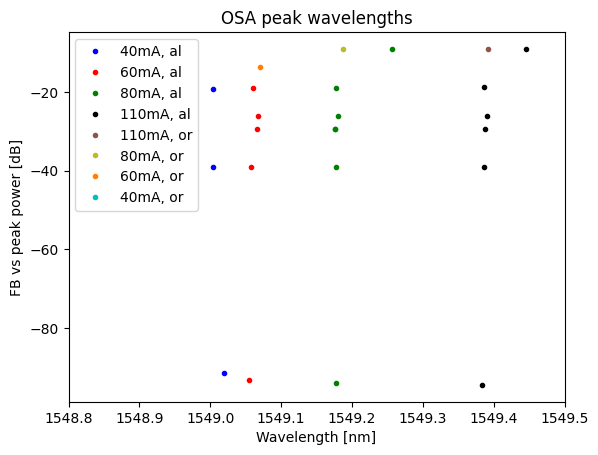

In [269]:
plot_OSA_data(directory)
plt.xlim([1548.8,1549.5])
plt.figure(0)
#plt.legend(['40mA','60mA','80mA','110mA'])
plt.xlabel('Wavelength [nm]')
plt.ylabel('FB vs peak power [dB]')
plt.title('OSA peak wavelengths')
plt.legend()

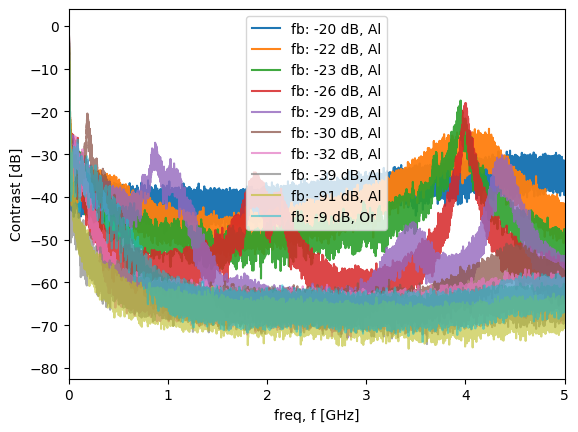

In [297]:
plot_rel_osc_data(directory)

Between 1.00 and 8.00 GHz
Gain: 30mA, Rel. osc.: 1.16 GHz, fb: -86 dB

Between 1.00 and 8.00 GHz
Gain: 40mA, Rel. osc.: 1.38 GHz, fb: -91 dB

Between 1.00 and 8.00 GHz
Gain: 60mA, Rel. osc.: 2.59 GHz, fb: -93 dB

Between 1.00 and 8.00 GHz
Gain: 80mA, Rel. osc.: 3.74 GHz, fb: -94 dB

Gain: 110mA -94.5127459753705
Gain: 110mA -48.79120119868568
Gain: 110mA -38.99386837755416
Gain: 110mA -26.113555907515313
Gain: 110mA -29.285091964541145
Between 1.50 and 8.00 GHz
Gain: 80mA
100µW fb, Rel. osc.: 3.02 GHz 

Between 1.50 and 8.00 GHz
Gain: 80mA
100µW fb, Rel. osc.: 3.21 GHz 

Between 1.50 and 8.00 GHz
Gain: 60mA
100µW fb, Rel. osc.: 2.63 GHz 

Between 0.0020 and 8.00 GHz
Gain: 110mA -9.035223359394507
Gain: 110mA -9.009766276785445


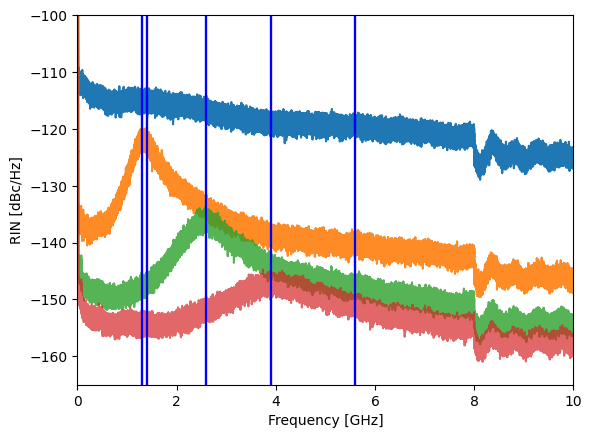

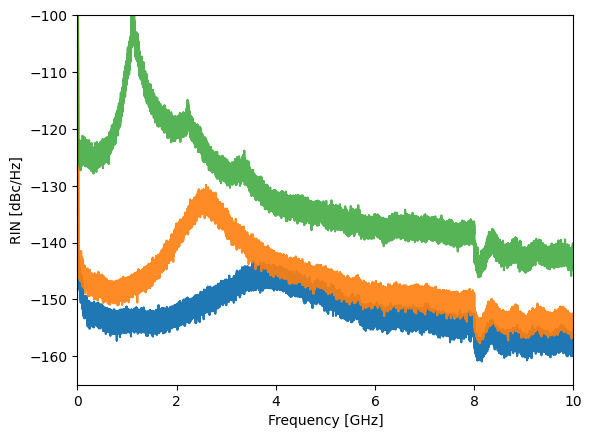

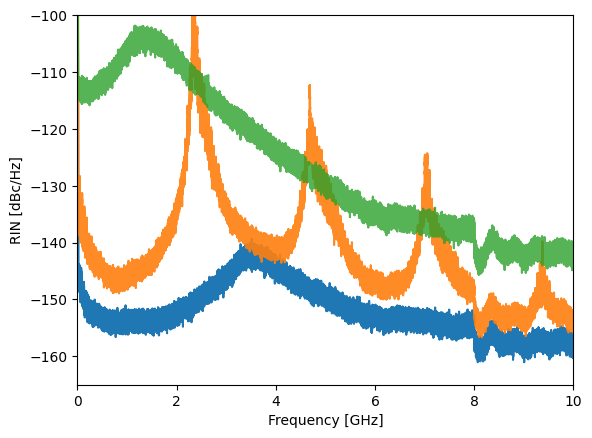

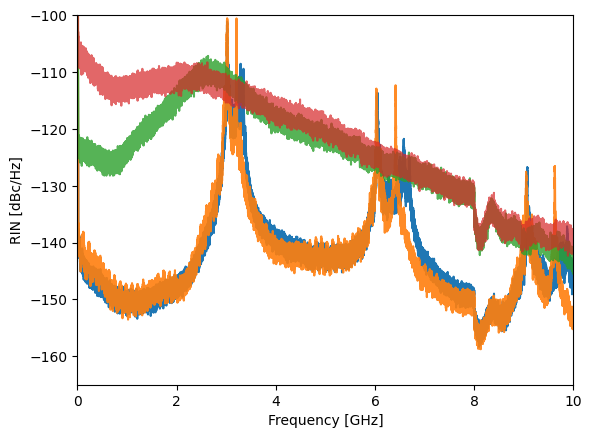

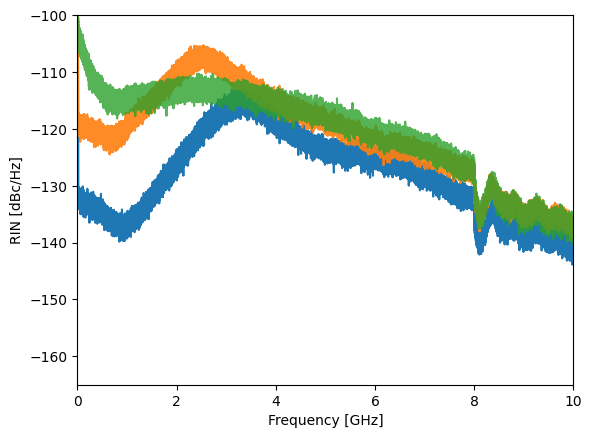

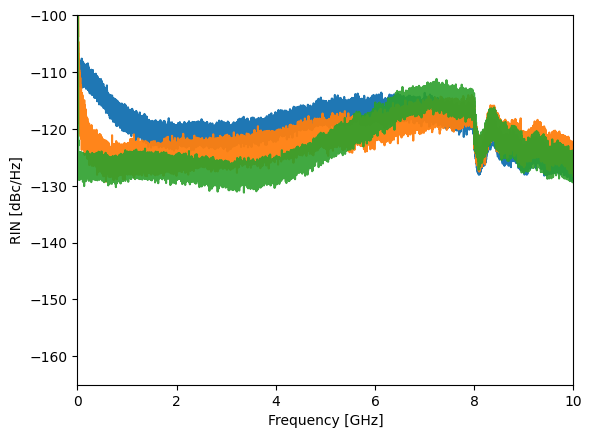

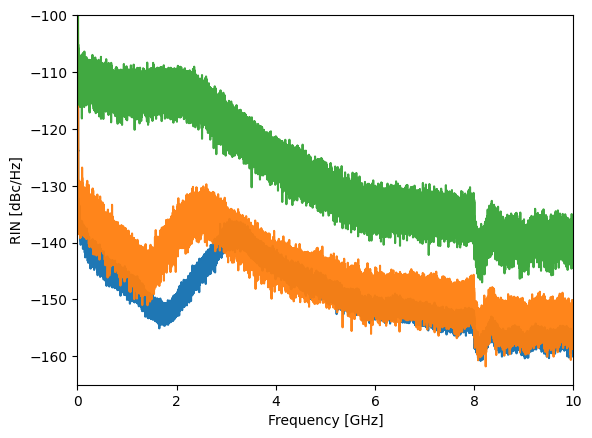

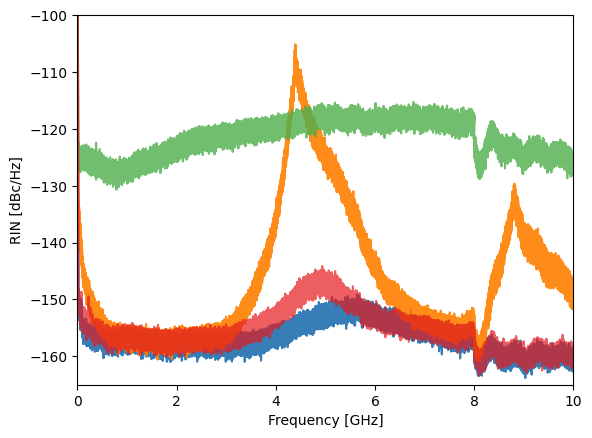

In [359]:
plot_intensity_data(directory)

In [316]:
signal.find_peaks_cwt(get_data(paths_intensity[3])[1]*1e-9,0.1)

array([ 7690,  7921,  7923, 14428, 14605, 18177, 37916, 43887, 47542,
       53734, 54387, 57448, 61625, 61787, 66376, 70654, 72863, 73705,
       75873, 80836, 80839, 80864, 80961, 81005, 81030, 81040, 81057,
       81067, 81105, 81119, 81127, 81162, 81179, 81228, 81342, 81375,
       81392, 85736, 85927, 86095, 86138, 86266, 89743, 90164, 90513,
       90550, 90591, 90681, 90690, 90934, 94395, 94817, 95241, 95329,
       95472, 95861, 99597, 99726, 99728], dtype=int64)

In [315]:
xs[81343]

8134300160.0

In [ ]:
get_header(paths_intensity[8])

[[' 105.1uW output', ' fb = 10.19uW', ' Gain: 110mA', ' pol: peak minimum\n']]

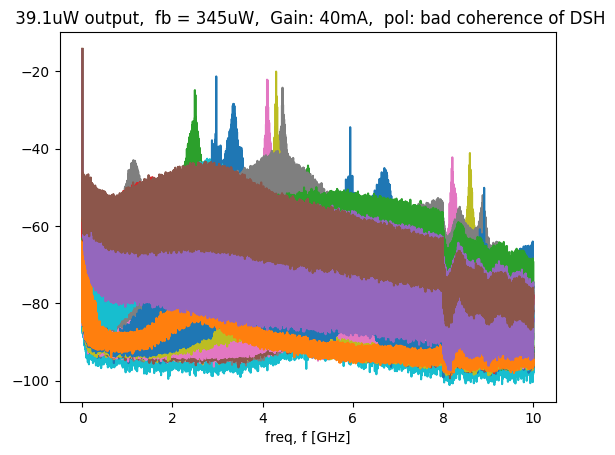

In [ ]:
for i in range(36):
    
    plot_data(paths_intensity[i])

In [ ]:
10**(80/10)*1e-9

0.1

In [ ]:
np.sqrt(1/(10**(-149.13719584/10)/(16*np.pi*1e6)))*1e-9

202.99938382375043